In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
from struct import unpack 

In [ ]:
!unzip -q /home/quocanh/Downloads/bike_motorbike_dataset.zip -d ./

In [2]:
ds_path = "./"
bike_ds = os.path.join(ds_path, "bike")
motorbike_ds = os.path.join(ds_path, "motorbike")

In [ ]:
# Check corrupted images and delete
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2]) # unpack image data
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break  


def delete_broken_image(img_dir):
    for f in os.listdir(img_dir):
        img_name = os.path.join(img_dir, f)
        img = JPEG(img_name) 
        try:
            img.decode()   
        except:
            print(f"Delete {img_name}")
            os.remove(img_name)

In [ ]:
delete_broken_image(bike_ds)
delete_broken_image(motorbike_ds)

In [3]:
bike_imgs = len(os.listdir(bike_ds))
motorbike_imgs = len(os.listdir(motorbike_ds))

print(f"There are {bike_imgs} bike images and {motorbike_imgs} motorbike images.")

There are 6044 bike images and 6067 motorbike images.


In [4]:
# Image size to be rescaled
input_size = (64, 64)

In [5]:
# Convert image to numpy array and flatten
def vectorize_image(image):
    img = Image.open(image).convert("L")
    img_resize = img.resize(input_size)

    img_arr = np.array(img_resize)
    img_vector = img_arr.flatten()
    
    return img_vector

In [6]:
X_bike_train = np.array( [vectorize_image(os.path.join(bike_ds, x)) for x in tqdm(os.listdir(bike_ds), desc="Vectorizing bikes")] )
X_motorbike_train = np.array( [vectorize_image(os.path.join(motorbike_ds, x)) for x in tqdm(os.listdir(motorbike_ds), desc="Vectorizing motorbikes")] )
# Normalize image is a must to appropriate parameters update and faster convergence
X_train = np.vstack((X_bike_train, X_motorbike_train)) / 255

Y_bike_train = np.zeros((bike_imgs, ))
Y_motorbike_train = np.ones((motorbike_imgs, ))
Y_train = np.concatenate((Y_bike_train, Y_motorbike_train))

Vectorizing motorbikes:   3%|▎         | 169/6067 [00:03<01:51, 53.00it/s]/home/quocanh/anaconda3/envs/vision/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Vectorizing motorbikes: 100%|██████████| 6067/6067 [02:05<00:00, 48.19it/s]


In [7]:
# Split dataset into 75% train, 25% test
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=12)
print(f"Number of train samples: {X_train.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")

Number of train samples: 9083
Number of test samples: 3028


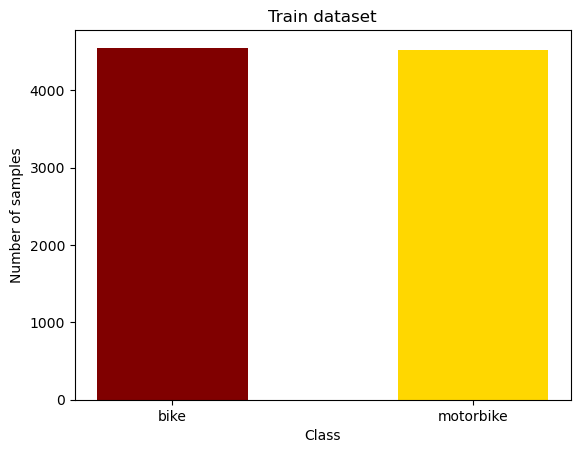

In [8]:
plt.bar(["bike", "motorbike"], [np.sum(Y_train==0), np.sum(Y_train==1)] , color =["maroon", "gold"],width = 0.5)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Train dataset")
plt.show()

In [9]:
def gradient_descent(x, y, w, b, learning_rate):
    """
    Gradient descent for linear regression 
 
    Args:
      x (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
      learning_rate (float)      : learning rate
    Returns
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
      total_loss (float) : Total loss of training set
      total_acc (float) : Total accuracy of training set
    """
    
    m, n = x.shape
    dj_dw = np.zeros((n, ))
    dj_db = 0
    eps = 1e-10 # add this tiny value to avoid log(0)
    
    # Build logistic model
    # using sigmoid function
    linear_model = np.dot(x, w) + b # (m, )
    logistic_model = 1 / (1+np.exp(-linear_model)) # (m, )
    
    # Error between prediction and ground truth
    diff = logistic_model - y
    
    # Compute the gradient of the cost w.r.t. the parameters w and b
    dj_dw = np.dot(x.T, diff) / m
    dj_db = np.sum(diff) / m
    
    # Update Parameters using w, b, alpha and gradient
    w = w - learning_rate * dj_dw               
    b = b - learning_rate * dj_db     
    
    # Total loss of training set
    train_loss = ( -np.dot(y.T, np.log(logistic_model+eps)) - np.dot((1-y).T, np.log(1-logistic_model+eps)) ) / m
    # Total accuracy of training set
    train_predict = np.where(logistic_model > 0.5, 1., 0.)
    train_acc = np.sum(train_predict == y) / m
    
    return w, b, train_acc, train_loss

In [10]:
def train(x, y, w, b, learning_rate, epochs):
    cost_hist = []
    acc_hist = []
    patience = 0
    
    for i in range(epochs+1):
        # Calculate the gradient and update the parameters
        w, b, acc, loss  = gradient_descent(x, y, w, b, learning_rate)
        cost_hist.append(loss)
        acc_hist.append(acc)
                    
        if i%500 == 0:
            print(f"\nEpoch {i}: Loss = {cost_hist[-1]:.4f} | Accuracy = {acc_hist[-1]:.4f}")
            
        # If loss is not improved for 25 epochs, reduce learning rate
        if i > 1:
            if cost_hist[i] > cost_hist[i-1]:
                patience += 1
                if patience > 25:
                    learning_rate  = learning_rate * 0.5
                    print(f"\nLearning rate decreased to {learning_rate}")
                    patience = 0

    # return cost history for graphing
    return w, b, cost_hist, acc_hist         

In [18]:
# Initialize weights and biases
w0  = np.zeros_like(X_train[0])
b0  = 0.

# Set learning rate and iterations
learning_rate = 0.1
epochs = 10000

w_out, b_out, cost_hist, acc_hist  = train(X_train, Y_train, w0, b0, learning_rate, epochs) 
print(f"\nUpdated parameters: w = {w_out} | b = {b_out} | Accuracy = {acc_hist[-1]:.4f} | Loss = {cost_hist[-1]:.4f}")


Epoch 0: Loss = 0.6931 | Accuracy = 0.5013

Learning rate decreased to 0.05

Epoch 100: Loss = 1.2128 | Accuracy = 0.7785

Epoch 200: Loss = 2.5317 | Accuracy = 0.6191

Learning rate decreased to 0.025

Epoch 300: Loss = 0.7020 | Accuracy = 0.7929

Epoch 400: Loss = 0.5889 | Accuracy = 0.7973

Epoch 500: Loss = 0.5227 | Accuracy = 0.7983

Epoch 600: Loss = 0.4802 | Accuracy = 0.8001

Epoch 700: Loss = 0.4540 | Accuracy = 0.8017

Learning rate decreased to 0.0125

Epoch 800: Loss = 0.4473 | Accuracy = 0.8026

Epoch 900: Loss = 0.4356 | Accuracy = 0.8035

Epoch 1000: Loss = 0.4267 | Accuracy = 0.8025

Epoch 1100: Loss = 0.4195 | Accuracy = 0.8038

Epoch 1200: Loss = 0.4134 | Accuracy = 0.8058

Epoch 1300: Loss = 0.4083 | Accuracy = 0.8073

Epoch 1400: Loss = 0.4039 | Accuracy = 0.8084

Epoch 1500: Loss = 0.4001 | Accuracy = 0.8110

Epoch 1600: Loss = 0.3968 | Accuracy = 0.8120

Epoch 1700: Loss = 0.3939 | Accuracy = 0.8128

Epoch 1800: Loss = 0.3914 | Accuracy = 0.8147

Epoch 1900: Loss

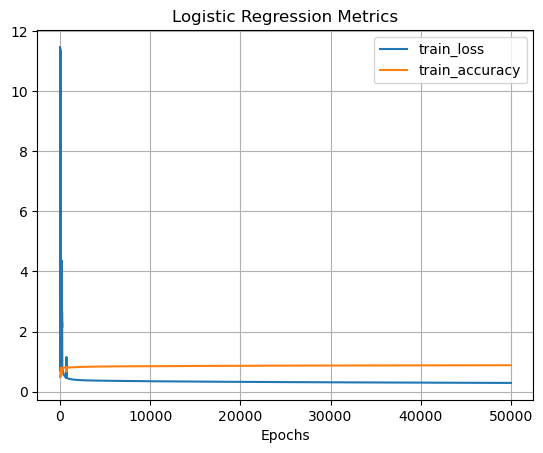

In [19]:
plt.plot(cost_hist, label='train_loss')
plt.plot(acc_hist, label='train_accuracy')
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.title('Logistic Regression Metrics')
plt.grid("on")
plt.show()

In [20]:
predictions_score = 1 / (1+np.exp( -np.dot(X_test, w_out) + b_out ))
predictions_label = np.where(predictions_score > 0.5, 1., 0.)

test_acc = np.mean(predictions_label == Y_test) * 100
test_loss = ( -np.dot(Y_test.T, np.log(predictions_score)) - np.dot((1-Y_test).T, np.log(1-predictions_score)) ) / predictions_score.shape[0] * 100

print(f"Test accuracy: {test_acc:.2f}%")
print(f"Test loss: {test_loss:.2f}%")

Test accuracy: 74.31%
Test loss: 59.93%
